In [4]:
test_dir = "/kaggle/input/fer2013/test"
train_dir = "/kaggle/input/fer2013/train"

print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))


7
7


2024-04-11 06:26:01.045337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 06:26:01.045593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 06:26:01.286860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(48, 48, 3)

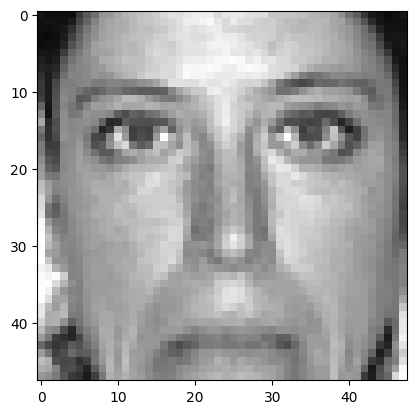

In [7]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
img = cv2.imread("/kaggle/input/fer2013/test/disgust/PrivateTest_11895083.jpg")
plt.imshow(img)
img.shape

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale =1.0/255.0,
                                   rotation_range = 40,
                                  width_shift_range =0.2,
                                  height_shift_range = 0.2,
                                  horizontal_flip =True)
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)


trainDatagen = train_datagen.flow_from_directory(train_dir,target_size =(48,48),batch_size = 100 ,
                                                 class_mode ='categorical',color_mode= 'rgb')

valdatagen = val_datagen.flow_from_directory(test_dir, target_size= (48,48),batch_size = 100,
                                               class_mode = "categorical",color_mode = 'rgb')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
import tensorflow as tf

# Define the path to the downloaded ResNet50 weights file
weights_path = '/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Define your ResNet50 model with input shape (48, 48, 3) and load the downloaded weights
base_model = tf.keras.applications.ResNet50(input_shape=(48, 48, 3), include_top=False, weights=None)

# Load the weights from the downloaded H5 file
base_model.load_weights(weights_path)


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(base_model)
model.add(Conv2D(filters =32,kernel_size =3,activation ='relu',padding = 'same',input_shape = (48,48,4)))
model.add(Conv2D(filters = 64, kernel_size =3,activation = 'relu',padding ='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters =128,kernel_size =3,activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=3,padding ='same'))
model.add(Conv2D(filters =128,kernel_size =3,activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=3,padding ='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

In [22]:
model.compile(optimizer = Adam(learning_rate=0.001,decay= 1e-6,amsgrad = 'True'),
             loss ='categorical_crossentropy',
             metrics = ['accuracy'])

In [23]:
class mycallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs,logs={}):
        if(logs.get('accuracy')>=0.99):
            self.model.stop_training = True
            print("model reached amazing accuracy")

In [ ]:
history = model.fit(trainDatagen,validation_data=valdatagen,batch_size =32,epochs= 50,shuffle=True)

Epoch 1/50
193/288 ━━━━━━━━━━━━━━━━━━━━ 8:36 5s/step - accuracy: 0.2838 - loss: 1.7471

In [ ]:
for X,Y in valdatagen:
    break

In [ ]:
results = model.evaluate(X,Y,batch_size =128)

In [ ]:
acc =history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))